In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%pip install mne PyWavelets scipy antropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.8 MB/s eta 0:00:00


In [ ]:
import mne

# Load your EEG file
file_path = '/content/drive/MyDrive/signal/Dementia edf/00004.edf'  # Replace with the actual file path
raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

# Get the sampling rate
sampling_rate = raw.info['sfreq']
print(f"Sampling Rate: {sampling_rate} Hz")


Sampling Rate: 200.0 Hz


Processing Complete. CSV saved!


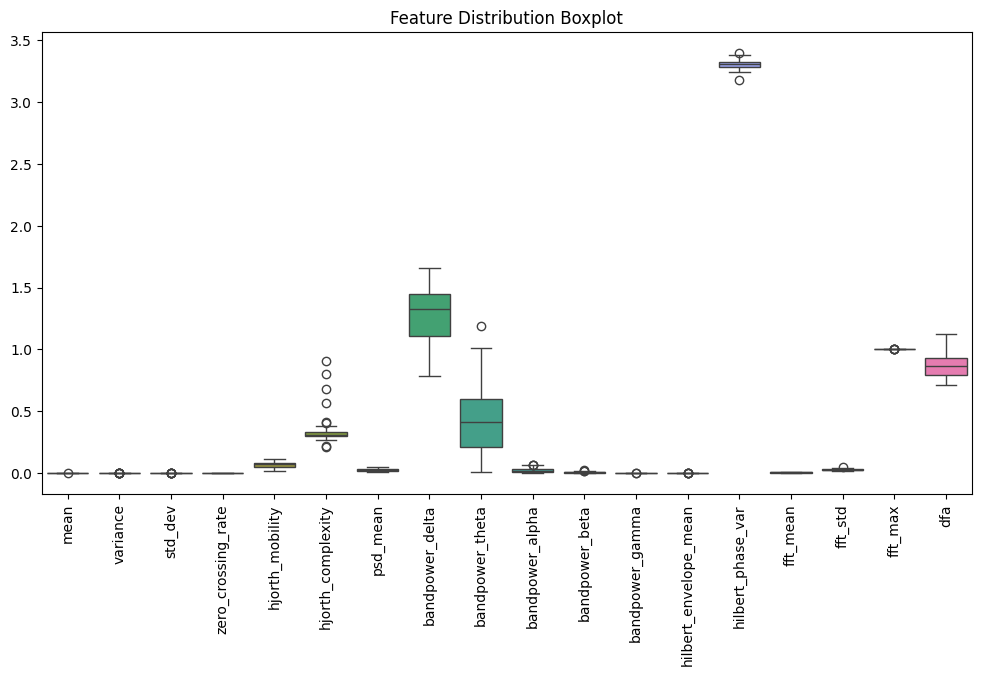

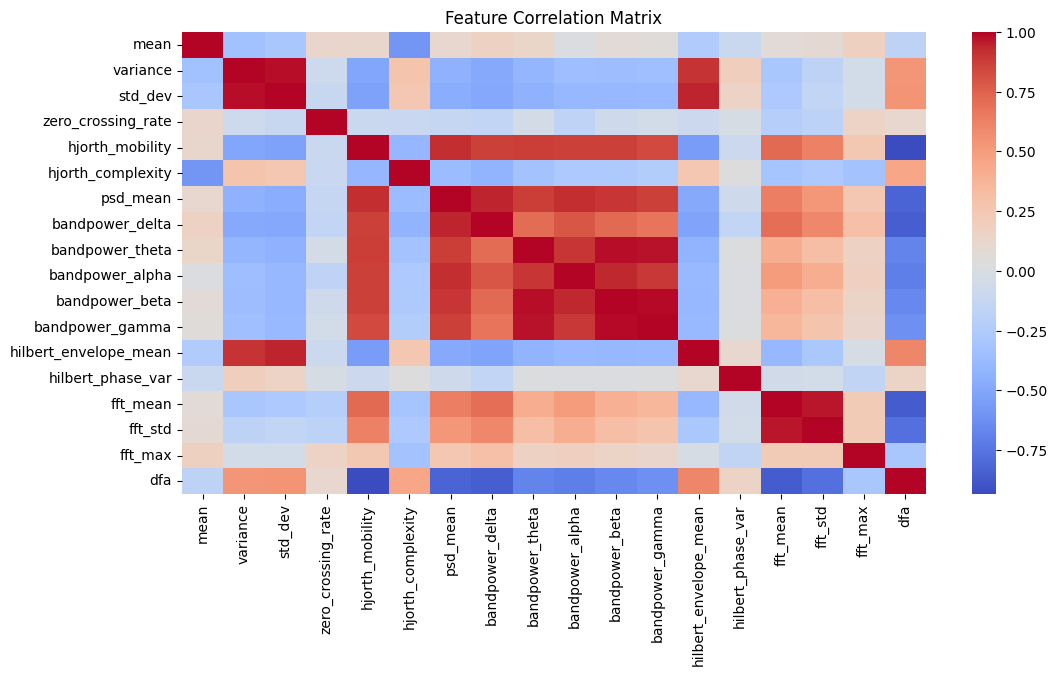

In [4]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.signal import butter, lfilter, iirnotch, welch, hilbert, detrend
import pywt
from scipy.fftpack import fft
import antropy as ant
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Define constants
DATA_DIRS = {"Normal": "/content/drive/MyDrive/signal/Normal edf", "MCI": "/content/drive/MyDrive/signal/MCI edf", "Dementia": "/content/drive/MyDrive/signal/Dementia edf"}
SAMPLING_RATE = 200  # Adjusted based on detected sampling rate
DURATION = 2 * 60  # 2 minutes in seconds
BANDPASS_FILTER = (0.1, 35)
NOTCH_FREQ = 50

# Bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

# Notch filter
def notch_filter(data, freq, fs, quality=30):
    b, a = iirnotch(freq, quality, fs)
    return lfilter(b, a, data)

# Wavelet Transform for artifact removal
def wavelet_denoise(data, wavelet='db4'):
    max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet).dec_len)
    max_level = max(1, min(4, max_level))  # Ensure level is within valid bounds
    coeffs = pywt.wavedec(data, wavelet, level=max_level)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # Remove high frequencies
    return pywt.waverec(coeffs, wavelet)[:len(data)]

# Feature extraction with normalization
def extract_features(data, label):
    features = {}
    data = detrend(data)  # Remove any linear trend to improve zero-crossing detection
    data = data - np.mean(data)  # Centering the signal

    features["mean"] = np.mean(data)
    features["variance"] = np.var(data)
    features["std_dev"] = np.std(data)
    features["zero_crossing_rate"] = np.sum(np.diff(np.sign(data))) / len(data)

    # Hjorth Parameters
    diff_data = np.diff(data)
    mobility = np.std(diff_data) / features["std_dev"] if features["std_dev"] != 0 else 0
    diff_diff_data = np.diff(diff_data)
    complexity = np.std(diff_diff_data) / np.std(diff_data) if np.std(diff_data) != 0 else 0
    features["hjorth_mobility"] = mobility
    features["hjorth_complexity"] = complexity

    # Power Spectral Density (PSD) with MinMax Scaling
    nperseg = min(256, len(data))  # Adjust dynamically to avoid warnings
    freqs, psd = welch(data, fs=SAMPLING_RATE, nperseg=nperseg, scaling='density')
    psd = MinMaxScaler().fit_transform(psd.reshape(-1, 1)).flatten()
    features["psd_mean"] = np.mean(psd)

    # Frequency Band Power (Apply log transform for better scaling)
    bands = {"delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 13), "beta": (13, 30), "gamma": (30, 45)}
    for band, (low, high) in bands.items():
        idx = np.where((freqs >= low) & (freqs <= high))
        features[f"bandpower_{band}"] = np.log1p(np.sum(psd[idx]))

    # Hilbert Transform Features
    analytic_signal = hilbert(data)
    features["hilbert_envelope_mean"] = np.mean(np.abs(analytic_signal))
    features["hilbert_phase_var"] = np.var(np.angle(analytic_signal))

    # Fourier Transform Features with MinMax Scaling
    fft_values = np.abs(fft(data))[:len(data) // 2]  # Take first half of FFT spectrum
    fft_values = MinMaxScaler().fit_transform(fft_values.reshape(-1, 1)).flatten()
    features["fft_mean"] = np.mean(fft_values)
    features["fft_std"] = np.std(fft_values)
    features["fft_max"] = np.max(fft_values)

    # Detrended Fluctuation Analysis (DFA)
    features["dfa"] = ant.detrended_fluctuation(data)

    features["label"] = label
    return features

# Load EEG data
def load_eeg_data(file_path, duration=DURATION):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.crop(tmax=duration)
    return raw.get_data()

# Process all EEG files
def process_all_files():
    feature_list = []
    for label, folder in DATA_DIRS.items():
        files = sorted(os.listdir(folder))[:20]
        for file in files:
            file_path = os.path.join(folder, file)
            raw_data = load_eeg_data(file_path)
            raw_data = bandpass_filter(raw_data, *BANDPASS_FILTER, SAMPLING_RATE)
            raw_data = notch_filter(raw_data, NOTCH_FREQ, SAMPLING_RATE)
            raw_data = np.array([wavelet_denoise(ch) for ch in raw_data])  # Apply per channel
            feature_list.append(extract_features(raw_data.flatten(), label))

    df = pd.DataFrame(feature_list)
    df.to_csv("processed_eeg_data_A.csv", index=False)
    print("Processing Complete. CSV saved!")

# Feature validation visualization
def validate_features(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df.drop(columns=['label']))
    plt.xticks(rotation=90)
    plt.title("Feature Distribution Boxplot")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.heatmap(df.drop(columns=['label']).corr(), cmap="coolwarm", annot=False)
    plt.title("Feature Correlation Matrix")
    plt.show()

# Run processing
process_all_files()

# Load processed data and validate
df = pd.read_csv("processed_eeg_data_A.csv")
validate_features(df)


Training CNN...

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.2943 - loss: 1.1159 - val_accuracy: 0.3333 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3867 - loss: 1.0625 - val_accuracy: 0.3333 - val_loss: 1.0497 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3555 - loss: 1.0508 - val_accuracy: 0.3333 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3021 - loss: 1.0414 - val_accuracy: 0.3333 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3880 - loss: 1.0198 - val_accuracy: 0.4583 - val_loss: 0.9739 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4089 - loss: 0.9944 - val_accuracy: 0.4583 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4857 - loss: 0.9759 - va

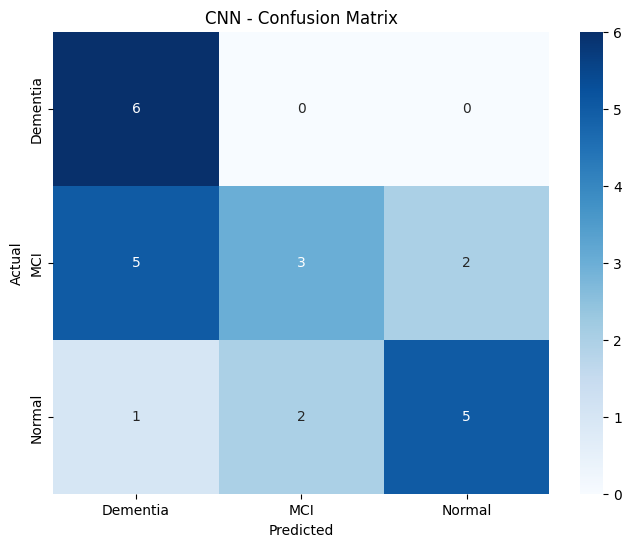


Training RNN (LSTM)...

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.3307 - loss: 1.0973 - val_accuracy: 0.4583 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4727 - loss: 1.0855 - val_accuracy: 0.5000 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4648 - loss: 1.0769 - val_accuracy: 0.5000 - val_loss: 1.0605 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5352 - loss: 1.0694 - val_accuracy: 0.4583 - val_loss: 1.0428 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5326 - loss: 1.0468 - val_accuracy: 0.4583 - val_loss: 1.0215 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5495 - loss: 1.0390 - val_accuracy: 0.4583 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4857 - loss: 1.03

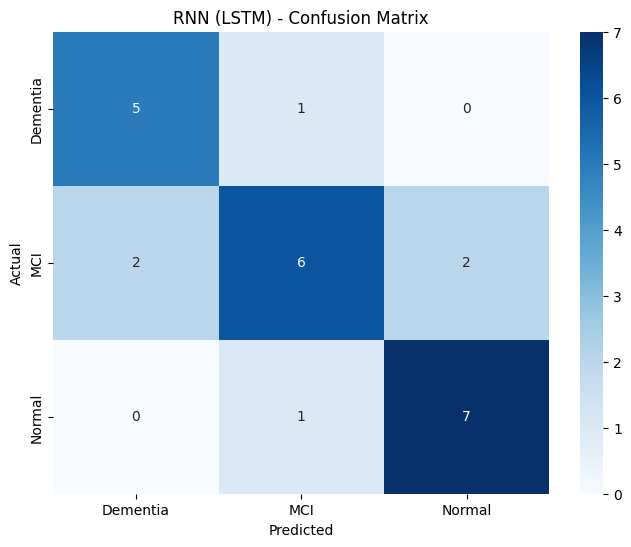


Training RNN Transformer (GRU + Attention + Positional Encoding)...

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - accuracy: 0.3151 - loss: 1.0982 - val_accuracy: 0.4167 - val_loss: 1.0897 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.4844 - loss: 1.0839 - val_accuracy: 0.5833 - val_loss: 1.0443 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4974 - loss: 1.0662 - val_accuracy: 0.5000 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4596 - loss: 1.0402 - val_accuracy: 0.5000 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5365 - loss: 0.9959 - val_accuracy: 0.5000 - val_loss: 0.9781 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5599 - loss: 0.9755 - val_accuracy: 0.5417 - val_loss: 0.9480 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━

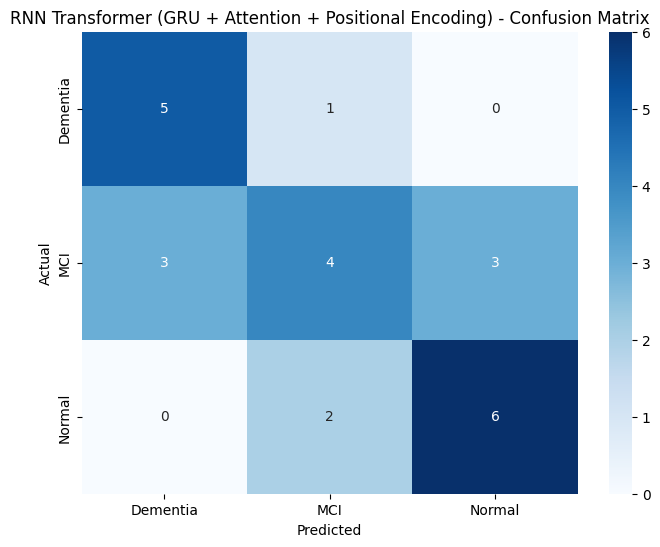

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, GRU, Dropout, BatchNormalization, MultiHeadAttention, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("/content/processed_eeg_data_A.csv")

# Prepare features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Feature Selection using Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = np.argsort(rf.feature_importances_)[-20:]  # Select top 20 features
X = X[:, feature_importances]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=min(20, X.shape[1]))  # Ensure at least 20 features for sliding windows
X = pca.fit_transform(X)

# Handle Class Imbalance using SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

# Sliding Window Data Augmentation
def create_sliding_windows(X, y, window_size=10, step=5):
    augmented_X, augmented_y = [], []
    if X.shape[1] < window_size:
        print("Warning: Not enough features for sliding window. Skipping augmentation.")
        return X, y

    for i in range(0, X.shape[1] - window_size + 1, step):
        augmented_X.append(X[:, i:i + window_size])
        augmented_y.append(y)

    return np.array(augmented_X).reshape(-1, window_size), np.repeat(y, len(augmented_X))

X, y = create_sliding_windows(X, y)

# Reshape data for CNN & RNN models
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for Conv1D
X_rnn = X[:, : (X.shape[1] // 3) * 3].reshape(X.shape[0], X.shape[1] // 3, 3)  # Reshape for RNN models

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_rnn, X_test_rnn, _, _ = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

# Positional Encoding Layer
def positional_encoding(dim):
    def layer(inputs):
        position = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        pos_encoding = tf.sin(tf.cast(position, dtype=tf.float32)[:, tf.newaxis] / 10000 ** (tf.range(dim, dtype=tf.float32) / dim))
        return inputs + pos_encoding
    return Lambda(layer)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# CNN Model
def build_cnn():
    inputs = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(np.unique(y)), activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Model (LSTM)
def build_rnn():
    inputs = Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
    x = LSTM(256, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(np.unique(y)), activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Transformer Model (GRU with Multi-Head Attention + Positional Encoding)
def build_rnn_transformer():
    inputs = Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
    x = positional_encoding(X_train_rnn.shape[2])(inputs)
    x = GRU(256, return_sequences=True)(x)
    x = GRU(128, return_sequences=True)(x)
    x = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(np.unique(y)), activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train & Evaluate Function
def train_and_evaluate(model, name, X_train_data, X_test_data):
    print(f"\nTraining {name}...\n")
    model.fit(X_train_data, y_train, epochs=50, batch_size=32, validation_data=(X_test_data, y_test), callbacks=callbacks)

    # Predictions
    y_pred = np.argmax(model.predict(X_test_data), axis=1)

    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print Scores
    print(f"\n{name} Scores:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Classification Report
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Train all models
cnn_model = build_cnn()
rnn_model = build_rnn()
rnn_transformer_model = build_rnn_transformer()

train_and_evaluate(cnn_model, "CNN", X_train, X_test)
train_and_evaluate(rnn_model, "RNN (LSTM)", X_train_rnn, X_test_rnn)
train_and_evaluate(rnn_transformer_model, "RNN Transformer (GRU + Attention + Positional Encoding)", X_train_rnn, X_test_rnn)
